Karol Kaszuba

Uroczyście oświadczam, że pracę wykonałem samodzielnie

In [20]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pa
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import pylab
import sys
from __future__ import unicode_literals
pylab.rcParams['figure.figsize'] = (17.0, 11.0)
matplotlib.rcParams['savefig.dpi'] = 250

In [21]:
data = pa.read_csv('wybory-2015-obwody.csv', low_memory=False, encoding="utf8")

In [22]:
#popraw blad w csvce (sa 2 komitety o numerze 16)
colnames = list(data.columns)
colnames[-1] = colnames[-1].replace("6", "7")
data.columns = colnames

In [23]:
data.fillna(0, inplace=True)

In [24]:
#retard party!
data["18 - Komitet Wyborczy Nieogarów"] = data[colnames[23]]
colnames = data.columns

In [25]:
for i in xrange(len(colnames)):
    s = "{0} : {1}".format(i, colnames[i])
    print s

0 : Nr okr.
Sejm
1 : Nr okr.
Senat
2 : TERYT
3 : Gmina
4 : Nr obw.
5 : Adres
6 : Liczba wyborców
7 : Otrzymane karty
8 : Niewykorzystane karty
9 : Wydane karty
10 : Liczba wyborców głosujących przez pełnomocnika
11 : Liczba wyborców głosujących na podstawie zaświadczenia
12 : Pakiety wyborcze
13 : Koperty zwrotne
14 : Koperty  bez oświadczenia
15 : Niepodpisane oświadczenie
16 : Koperty zwrotne bez koperty na kartę do głosowania
17 : Niezaklejona koperta na kartę do głosowania
18 : Koperty na kartę do głosowania wrzucone do urny
19 : Karty wyjęte z urny
20 : Karty wyjęte z kopert na karty do głosowania
21 : Karty nieważne
22 : Karty ważne
23 : Głosy nieważne
24 : w tym: z powodu postawienia znaku „X” obok nazwiska dwóch lub większej liczby kandydatów z różnych list
25 : w tym: z powodu niepostawienia znaku „X” obok nazwiska żadnego kandydata
26 : w tym: z powodu postawienia znaku „x” wyłącznie obok nazwiska kandydata z listy, której rejestracja została unieważniona
27 : Głosy ważne
28 

In [26]:
adresy = data["Adres"]

In [27]:
def get_int(s):
    if isinstance(s, int):
        return s
    if isinstance(s, float):
        return (int)(s)
    return (int)(str(s).replace(",", ""))

In [28]:
def glosy_na_komitety(obwody, partie, warunek=(lambda x: True)):
    glosy = []
    for i in partie:
        id_partii = i + 27
        ile = sum(get_int(data[colnames[id_partii]][obwod])
                  for obwod in obwody
                  if warunek(obwod))
        glosy.append(ile)
        #print "Liczba glosow na komitet {0} wyniosła {1}".format(komitet, ile)
    return glosy

In [29]:
def wykres(glosy, partie, title, xtitle, ytitle, percentage, color, savefile):
    max_y = 100
    while max_y <= max(glosy):
        max_y *= 10
    s = max_y / 20
    while max_y >= max(glosy) + s:
        max_y -= s
    
    pylab.rcParams['figure.figsize'] = (len(partie), 11)
    
    plot_width, plot_height = pylab.rcParams['figure.figsize']
    
    sq_len = (float(max_y)/(plot_height - 1.0)) * 0.8 * 0.9
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if title is not None:
        plt.title(title)
    if xtitle is not None:
        plt.xlabel(xtitle, labelpad=50)
    if ytitle is not None:
        plt.ylabel(ytitle)
        
    ax.bar(range(len(glosy)), glosy, color=color, edgecolor=color)
    ax.axis((0, len(glosy), 0, max_y))
    ax.get_xaxis().set_ticks([0.4 + i for i in xrange(len(glosy))])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticks([i for i in xrange(0, max_y + 1, max_y/20)])
    
    #chcemy, zeby ticksy na osiach ladnie wygladaly
    plt.tick_params(axis='x',
                    which='both',
                    bottom='off',
                    top='off')
    ax.get_yaxis().set_tick_params(direction='inout')
    ax.get_yaxis().tick_left()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #pokaz liczbe glosow nad barem
    for rect in ax.patches:
        rect.set_x(rect.get_x() + 0.1)
    
    for rect, ile in zip(ax.patches, glosy):
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 
                height+sq_len*0.2, 
                ile, 
                ha='center', 
                va='bottom')
        if percentage:
            ax.text(rect.get_x()+rect.get_width()/2, 
                    height+sq_len*0.5, 
                    "{0:.2f}%".format((ile+0.0)/sum(glosy)*100.0), 
                    ha='center', 
                    va='bottom',
                    color="darkgreen")
    
    #pokaz logo partii jako label pod barem
    for i in xrange(len(partie)):
        cirkul = matplotlib.patches.Rectangle((i + 0.1, -sq_len * 1.05),
                                              width=0.8,
                                              height=sq_len,
                                              color="white")
        nazwa = "logo/partia" + str(partie[i]) + ".png"
        bbox_image = matplotlib.image.BboxImage(cirkul.get_window_extent, clip_on=False, norm=None, origin=None)
        bbox_image.set_data(matplotlib.image.imread(nazwa))
        ax.add_artist(bbox_image)
        ax.add_patch(cirkul)
        
    if savefile:
        plt.savefig(savefile, dpi=fig.dpi)
    else:
        plt.show()
    return

In [30]:
def wykres_z_obwodow(obwody, partie=range(1, 18), warunek=(lambda x: True), savefile=None, title=None, color="orange"):
    glosy = glosy_na_komitety(obwody, partie, warunek)
    wykres(glosy=glosy, 
           partie=partie, 
           title=title,
           xtitle="Partie kandydujące",
           ytitle="Liczba głosów",
           percentage=True,
           color=color,
           savefile=savefile)
    return

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="nowoczesnalepszaodpo.png", 
                 color="blue", 
                 title="Wyniki wyborów w okręgach, gdzie Nowoczesna wygrała z PO",
                 warunek=(lambda x: (get_int(data[colnames[29]][x]) <= get_int(data[colnames[35]][x]))))

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="psllepszeodkukiza.png", 
                 color="lightgreen", 
                 title="Wyniki wyborów w okręgach, gdzie PSL wygrało z Kukiz'15",
                 warunek=(lambda x: (get_int(data[colnames[34]][x]) <= get_int(data[colnames[32]][x]))))

In [ ]:
wykres_z_obwodow(obwody=[i for i in xrange(len(adresy)) if (adresy[i].find("Warszawa") != -1)], 
                 savefile="mojokreg.png", 
                 color="brown",
                 title="Wyniki wyborów w moim okręgu",
                 partie=range(1,19))

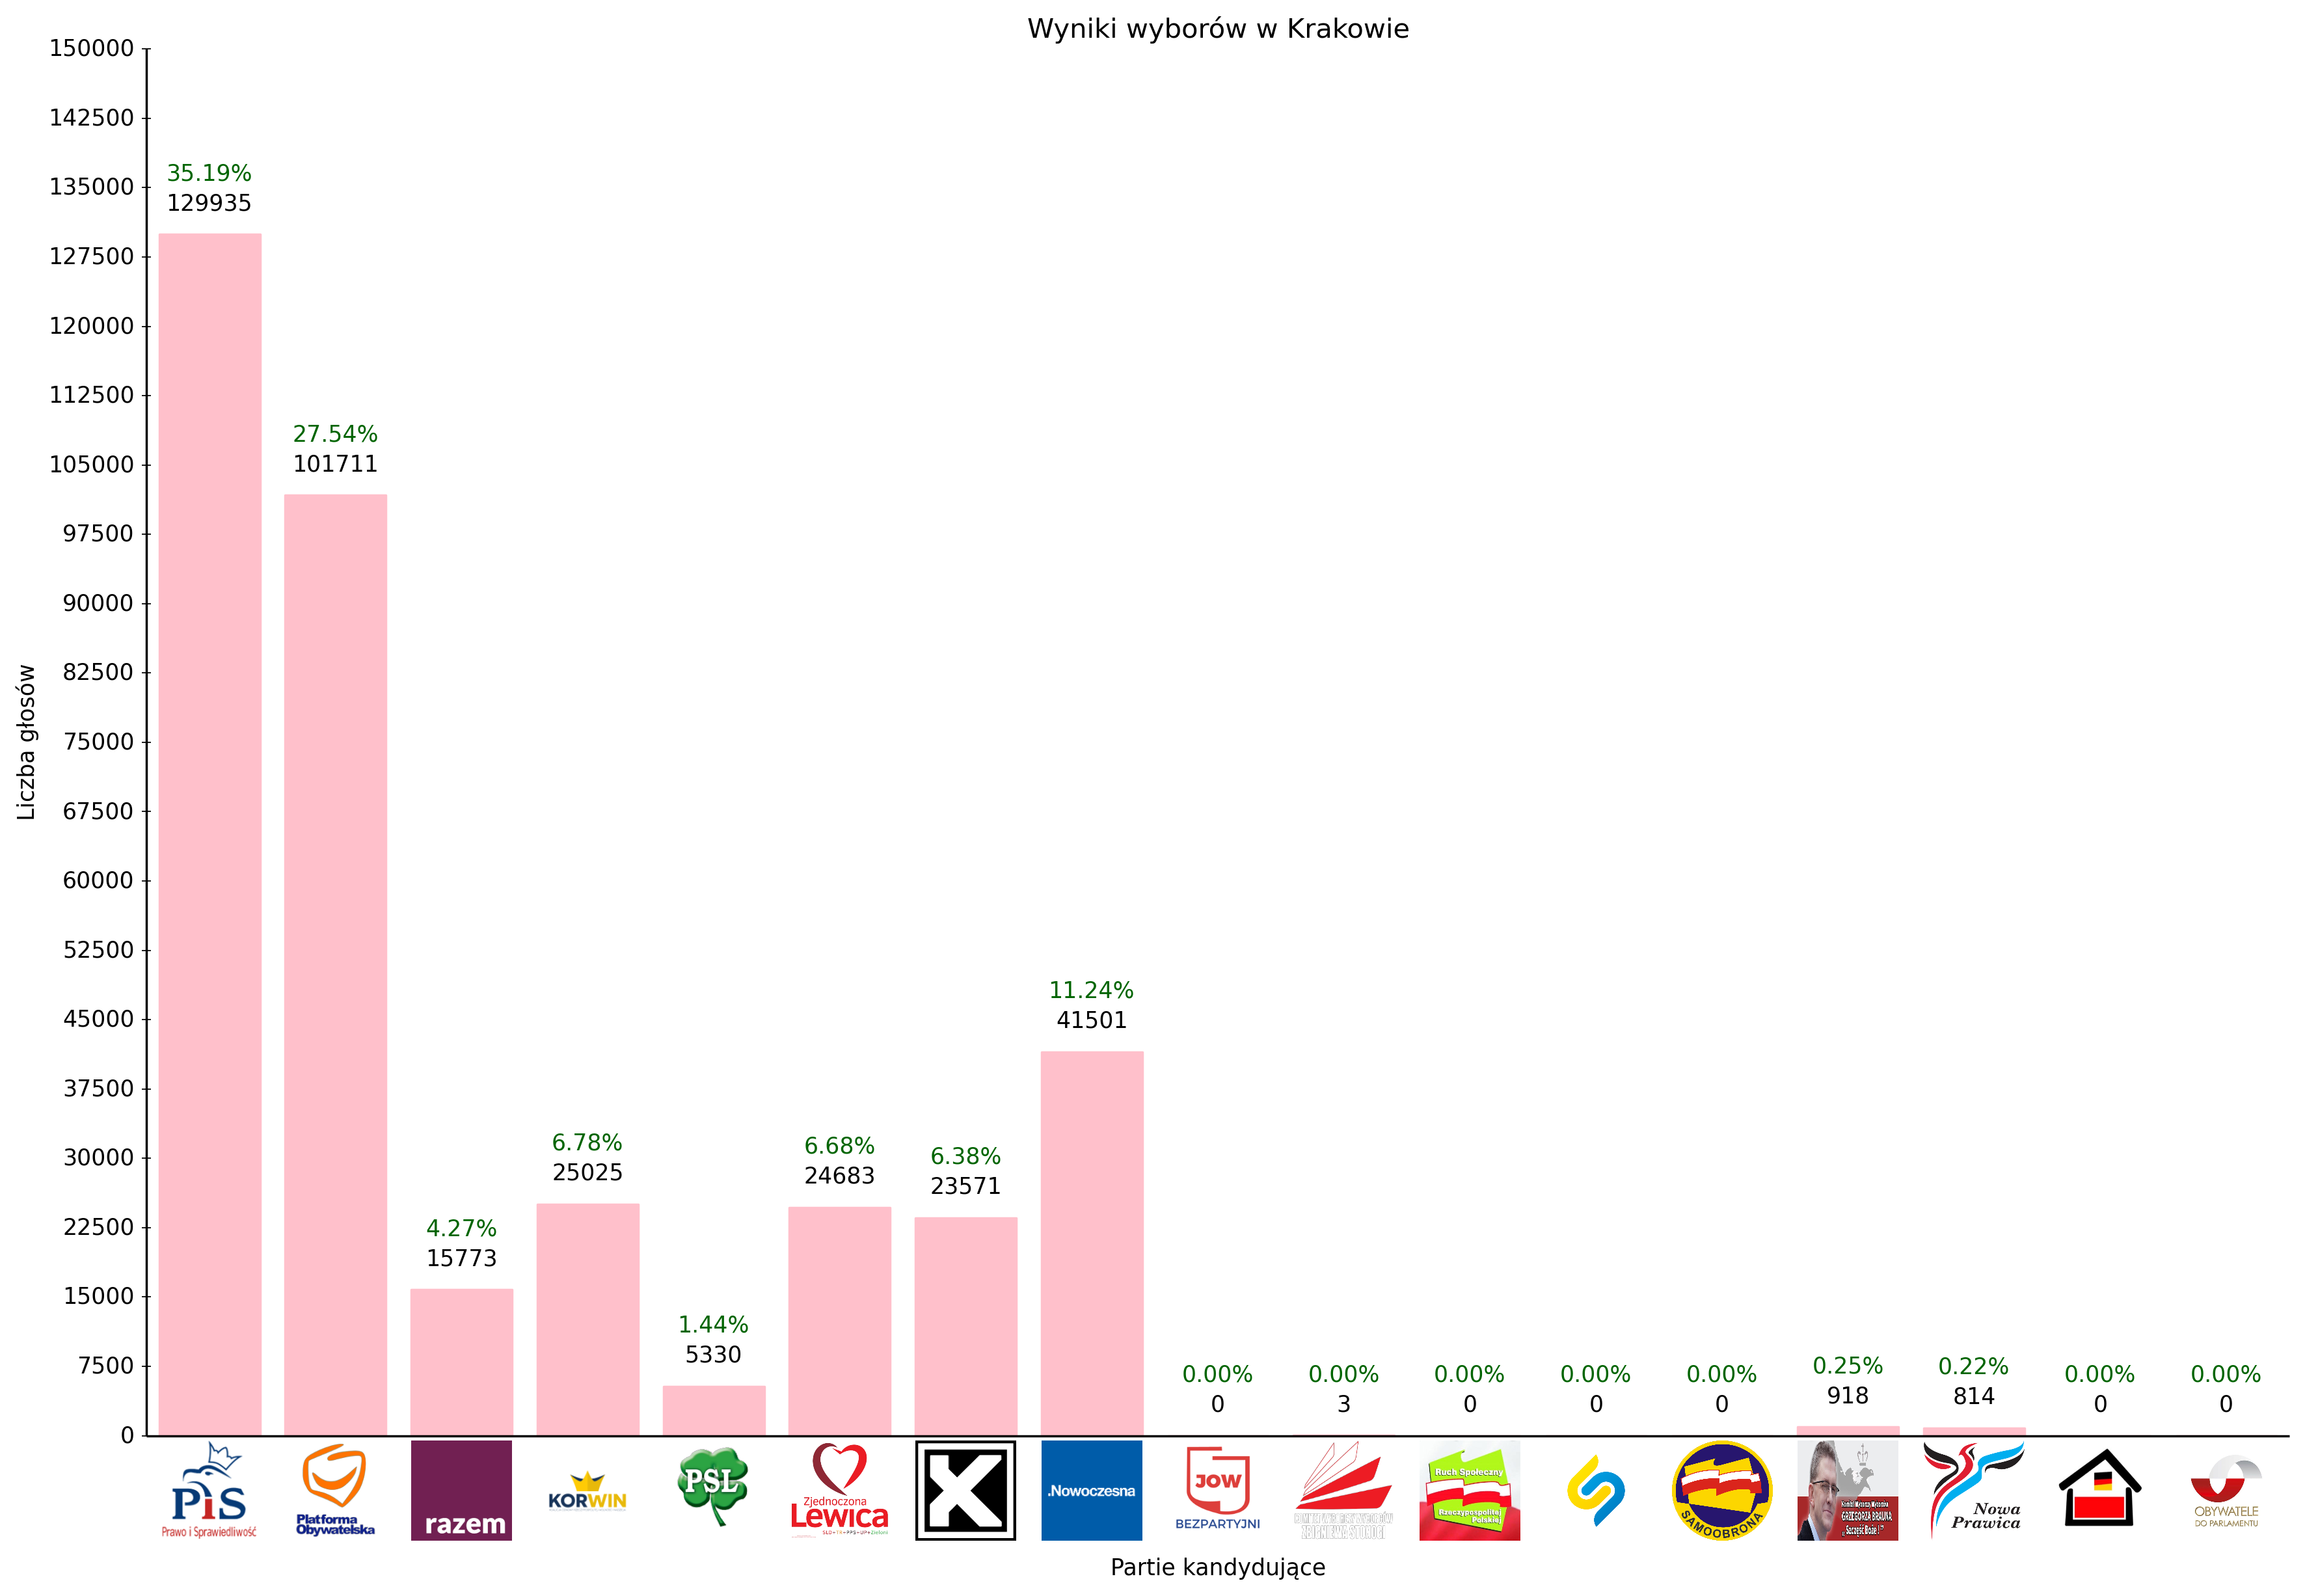

In [89]:
wykres_z_obwodow(obwody=[i for i in xrange(len(adresy)) if (adresy[i].find("Kraków") != -1)], 
                 savefile="krakow.png", 
                 color="pink", 
                 title="Wyniki wyborów w Krakowie")

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="calykraj.png", 
                 color="black", 
                 title="Wyniki wyborów w Polsce")

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="calykraj.png", 
                 color="gray", 
                 title="Wyniki wyborów w Polsce",
                 partie=range(1,19))

In [ ]:
wykres_z_obwodow(obwody=[i for i in xrange(len(adresy)) if (adresy[i].find("Mysłowice") != -1)], 
                 savefile="Mysłowice.png", 
                 color="pink", 
                 title="Wyniki wyborów w Mysłowicach",
                 partie=range(1,19))

In [31]:
#przeklepane z palca z wiki
mandaty_w_okregach = [12, 8,  14, 12, 13, 15, 12, 12, 
                      10, 9,  12, 8,  14, 10, 9,  10, 
                      9,  12, 20, 12, 12, 11, 15, 14, 
                      12, 14, 9,  7,  9,  9,  12, 9, 
                      16, 8,  10, 12, 9,  9,  10, 8,
                      12]

In [32]:
def dhondt(glosy, mandaty):
    def comp(x, y):
        if x[0] > y[0]:
            return -1
        if x[0] < y[0]:
            return 1
        if glosy[x[1]] > glosy[y[1]]:
            return 1
        if glosy[x[1]] < glosy[y[1]]:
            return -1
        return 0
        
    ilorazy = []
    for i in range(1, mandaty + 1):
        for j in xrange(len(glosy)):
            ilorazy.append((glosy[j] // i, j))
    ilorazy.sort(comp)
    
    wyniki = [0] * len(glosy)
    for i in xrange(mandaty):
        wyniki[ilorazy[i][1]] += 1
    return wyniki

In [33]:
def podzial_mandatow(partie):
    pelne_wyniki = np.array([0] * len(partie))
    full_wyniki = []
    for okreg in xrange(1, 42):
        obwody = [i for i in xrange(len(data)) if data[colnames[0]][i] == okreg]
        glosy = glosy_na_komitety(obwody, partie)
        wyniki = dhondt(glosy, mandaty_w_okregach[okreg - 1])
        full_wyniki.append(wyniki)
        pelne_wyniki = pelne_wyniki + np.array(wyniki)

    print "Podział mandatów do Sejmu:"
    for i in xrange(len(partie)):
        print "{0} otrzymał {1} mandatów.".format((colnames[partie[i] + 27].split("- "))[1], pelne_wyniki[i])
    
    return (full_wyniki, pelne_wyniki)

In [34]:
def wykres_mandatow(partie=[1,2,5,7,8,16]):
    _, mandaty = podzial_mandatow(partie)
    wykres(glosy=mandaty, 
           partie=partie,
           title="Podział mandatów do Sejmu",
           xtitle="Partie",
           ytitle="Liczba zdobytych mandatów",
           percentage=True,
           color="gold",
           savefile=False)
    return

In [ ]:
wykres_mandatow([1, 2, 5, 7, 8, 16, 18])

In [35]:
_, mandaty = podzial_mandatow([1, 2, 5, 7, 8, 16])

Podział mandatów do Sejmu:
Komitet Wyborczy Prawo i Sprawiedliwość otrzymał 235 mandatów.
Komitet Wyborczy Platforma Obywatelska RP otrzymał 138 mandatów.
Komitet Wyborczy Polskie Stronnictwo Ludowe otrzymał 16 mandatów.
Komitet Wyborczy Wyborców „Kukiz'15” otrzymał 42 mandatów.
Komitet Wyborczy Nowoczesna Ryszarda Petru otrzymał 28 mandatów.
Komitet Wyborczy Wyborców Mniejszość Niemiecka otrzymał 1 mandatów.


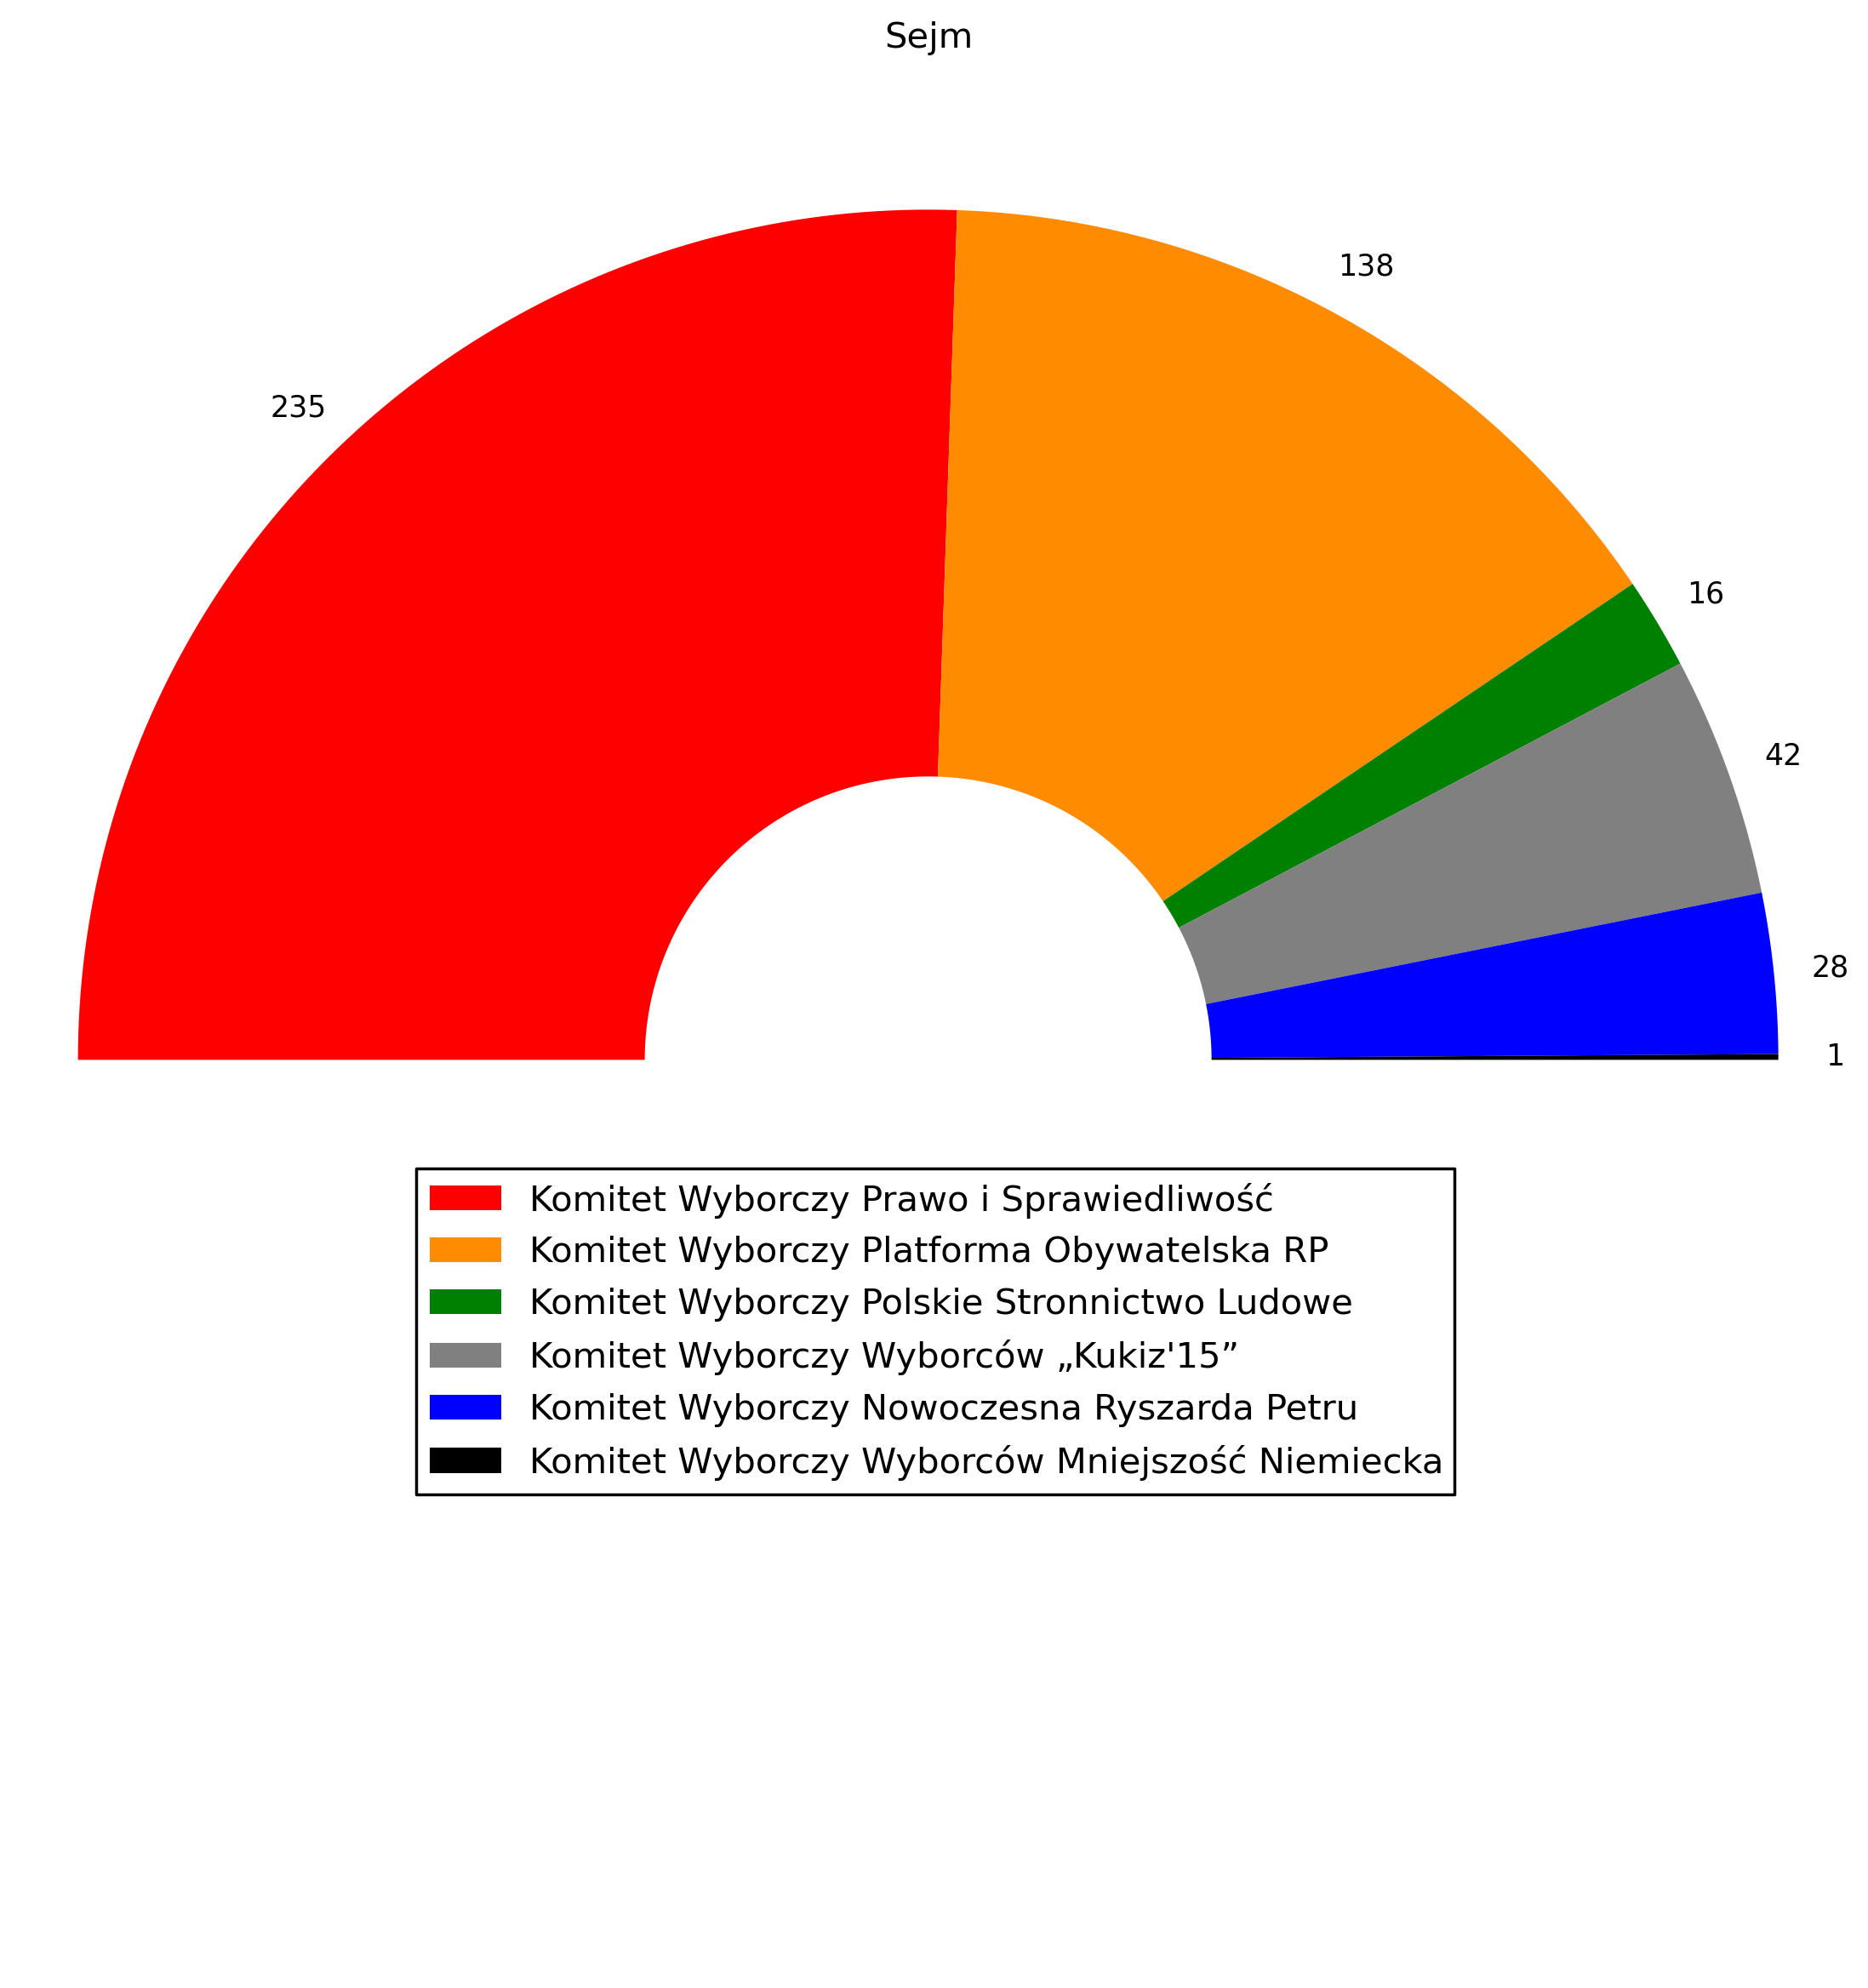

In [93]:
def wykres_sejm(partie, mandaty):
    
    partie = list(colnames[np.array(partie)+27])
    partie = [(x.split("- "))[1] for x in partie]

    theta = []
    width = []
    label = []
    pocz = np.pi
    for m in mandaty:
        width.append((m + 0.0)/460 * np.pi)
        pocz -= width[-1]
        theta.append(pocz)
        label.append((m + 0.0)/460 * 100)

    N = len(mandaty)
    radii = [1] * N

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_label(label)
    ax.set_title("Sejm")
    color=["red", "darkorange", "green", "gray", "blue", "black"]

    bars = ax.bar(theta, 
                  radii, 
                  width=width, 
                  bottom=0.5,
                  edgecolor="black",
                  lw=0,
                  color=color[:N])

    counter=0
    for t, w, m in zip(theta, width, mandaty):
        ax.text(t + w/2, 1.6, m, horizontalalignment = 'center', verticalalignment = 'center', rotation = 0)
        counter += 1

    ax.legend(bars, partie, bbox_to_anchor=(0.8, 0.45))

    fig.show()